In [47]:
# source: https://www.kaggle.com/code/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [48]:
fake = pd.read_csv("./data/Fake_del_hashtag.csv")

fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [49]:
# Counting by Subjects
for key, count in fake.subject.value_counts().items():
    print(f"{key}:\t{count}")

# Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


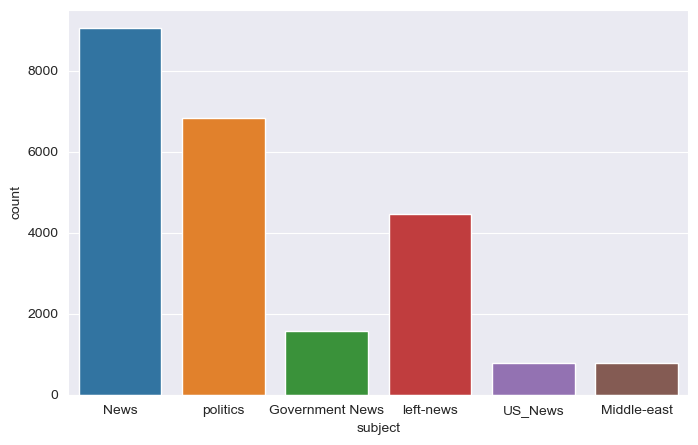

In [50]:
plt.figure(figsize=(8,5))
sns.countplot(x="subject", data=fake)
plt.show()

In [51]:
real = pd.read_csv("./data/True_del_hashtag.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [52]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [53]:
#Thus we have list of indices where publisher is not mentioned
#lets check
real.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [54]:
real.iloc[8970]
#yep empty
#will remove this soon

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [55]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)

        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [56]:
#Replace existing text column with new text
#add seperate column for publication info
real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [57]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [58]:
#checking for rows with empty text like row:8970
[index for index,text in enumerate(real.text.values) if str(text).strip() == '']
#seems only one :)

[8970]

In [59]:
#dropping this record
real = real.drop(8970, axis=0)

In [60]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [61]:
#Getting Total Rows
print(f"Total Records:\t{real.shape[0]}")

#Counting by Subjects
for key,count in real.subject.value_counts().items():
  print(f"{key}:\t{count}")

Total Records:	21416
politicsNews:	11271
worldnews:	10145


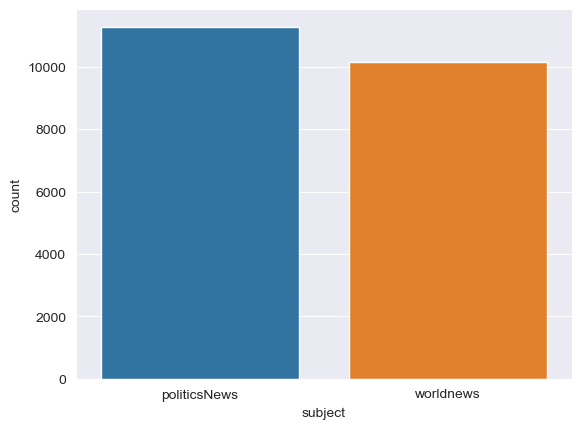

In [62]:
sns.countplot(x="subject", data=real)
plt.show()

In [63]:
# Adding class Information
real["class"] = 1
fake["class"] = 0

In [64]:
#Combining Title and Text
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [65]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
real = real.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [66]:
#Combining both into new dataframe
data = pd.concat([real, fake], ignore_index=True)
del real, fake

In [67]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dagma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dagma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [68]:
y = data["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data

In [69]:
import gensim

In [70]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [71]:
#vocab size
len(w2v_model.wv.index_to_key)

#We have now represented each of 122248 words by a 100dim vector.

122333

In [72]:
#see a sample vector for random word, lets say Corona
w2v_model.wv["corona"]

array([ 0.0105832 ,  0.01110497, -0.00603866,  0.00958166,  0.01679467,
       -0.0045197 ,  0.10345812,  0.07507852, -0.02125779, -0.07017027,
       -0.04768731, -0.00329743,  0.01507289, -0.01724575,  0.02189476,
       -0.07427832, -0.03471747, -0.04451355,  0.02592455, -0.01918528,
       -0.04857581,  0.045081  , -0.04677259, -0.04874604,  0.075766  ,
        0.04511417, -0.06390328,  0.02273214, -0.00254498,  0.00406894,
        0.01541051, -0.0469932 , -0.03798263, -0.04920206, -0.03234593,
        0.03026801,  0.00685702, -0.00992936,  0.00513367, -0.03888556,
       -0.01514544,  0.059526  , -0.0789489 , -0.03818368,  0.0837298 ,
        0.05432347, -0.01645989,  0.0197731 ,  0.0093406 ,  0.03658152,
        0.0100657 ,  0.00814292,  0.0035814 ,  0.0222139 , -0.00615151,
        0.08435251, -0.00293403,  0.02336248, -0.0376844 ,  0.11288474,
       -0.03363892,  0.02489379, -0.00521538,  0.04603484,  0.03824546,
       -0.00505277, -0.00409192,  0.03218433, -0.03757606,  0.02

In [73]:
w2v_model.wv.most_similar("iran")

[('tehran', 0.901603102684021),
 ('iranian', 0.7778300046920776),
 ('iranians', 0.6370635628700256),
 ('destabilizing', 0.6247583031654358),
 ('hezbollah', 0.6191214919090271),
 ('jcpoa', 0.6081749796867371),
 ('riyadh', 0.6057584285736084),
 ('nuclear', 0.6016877889633179),
 ('pyongyang', 0.5926427245140076),
 ('israel', 0.5878822207450867)]

In [74]:
w2v_model.wv.most_similar("fbi")

[('comey', 0.7348544001579285),
 ('cia', 0.6193503737449646),
 ('mueller', 0.6161051988601685),
 ('investigators', 0.6152615547180176),
 ('investigation', 0.5861411690711975),
 ('doj', 0.584226131439209),
 ('investigations', 0.5545183420181274),
 ('probe', 0.5367076396942139),
 ('inquiry', 0.5323750972747803),
 ('nunes', 0.5220969915390015)]

In [75]:
w2v_model.wv.most_similar("facebook")

[('reddit', 0.6839001774787903),
 ('instagram', 0.6334290504455566),
 ('fb', 0.628210723400116),
 ('google', 0.6143912076950073),
 ('gofundme', 0.5723263025283813),
 ('gizmodohopefully', 0.5700250267982483),
 ('online', 0.5682399868965149),
 ('blog', 0.5631327033042908),
 ('huffington', 0.5605655908584595),
 ('patheosthe', 0.5543521642684937)]

In [76]:
w2v_model.wv.most_similar("computer")

[('computers', 0.8258867263793945),
 ('software', 0.7890587449073792),
 ('electronic', 0.7688973546028137),
 ('malware', 0.7664406895637512),
 ('laptop', 0.7511839866638184),
 ('kaspersky', 0.7299817204475403),
 ('scanning', 0.7144132852554321),
 ('encrypted', 0.7101070284843445),
 ('accessed', 0.7010766863822937),
 ('servers', 0.6990916132926941)]

In [77]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

[('cruz', 0.5306706428527832),
 ('bush', 0.5233457684516907),
 ('elect', 0.5144397020339966),
 ('hillary', 0.489477276802063),
 ('crooked', 0.48834577202796936),
 ('incoming', 0.47764649987220764),
 ('course', 0.47215861082077026),
 ('actually', 0.45725902915000916),
 ('romney', 0.4510056972503662),
 ('americas_dad', 0.450891375541687)]

In [78]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [79]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[389, 395, 10494, 54, 5509, 1286, 4840, 315, 205, 16]

In [80]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


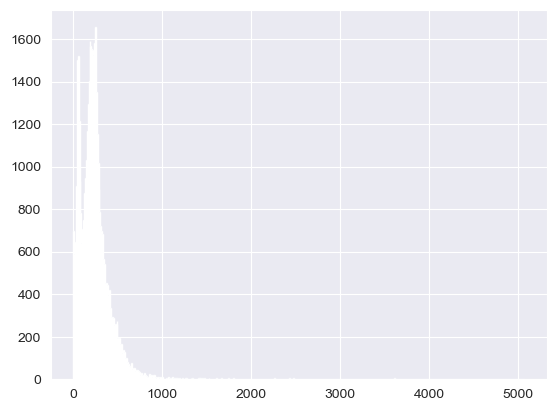

In [81]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :)

In [82]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
# Out of 48k news, 44k have less than 700 words

43984

In [83]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [84]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [85]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [86]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [87]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model.wv, word_index)

In [88]:
#Defining Neural Network
def build_model(emb_vectors, EMB_DIM, voc_size, length):
    mod = Sequential()
    #Non-trainable embeddidng layer
    mod.add(Embedding(voc_size, output_dim=EMB_DIM, weights=[emb_vectors], input_length=length, trainable=False))
    #LSTM
    mod.add(LSTM(units=128))
    mod.add(Dense(1, activation='sigmoid'))
    mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return mod


In [89]:
#Train test split
def split(X, y, seed):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    return X_train, X_test, y_train, y_test

In [90]:
result = []

In [91]:
for n in range(31):
    print("Processing iteration " + str(n))
    X_train, X_test, y_train, y_test = split(X, y, n)
    model = build_model(embedding_vectors, EMBEDDING_DIM, vocab_size, maxlen)
    model.fit(X_train, y_train, validation_split=0.3, epochs=6)
    #Prediction is in probability of news being real, so converting into classes
    # Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
    y_pred = (model.predict(X_test) >= 0.5).astype("int")
    # add y_test and y_pred to result for later use
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    result.append((acc, prec, rec, f1))

Processing iteration 0
Epoch 1/6
737/737 [==============================] - 223s 299ms/step - loss: 0.1331 - acc: 0.9534 - val_loss: 0.1251 - val_acc: 0.9550
Epoch 2/6
737/737 [==============================] - 232s 314ms/step - loss: 0.0827 - acc: 0.9716 - val_loss: 0.0398 - val_acc: 0.9853
Epoch 3/6
737/737 [==============================] - 235s 320ms/step - loss: 0.0363 - acc: 0.9877 - val_loss: 0.0372 - val_acc: 0.9880
Epoch 4/6
737/737 [==============================] - 239s 324ms/step - loss: 0.0404 - acc: 0.9869 - val_loss: 0.1545 - val_acc: 0.9492
Epoch 5/6
737/737 [==============================] - 235s 319ms/step - loss: 0.0815 - acc: 0.9710 - val_loss: 0.0568 - val_acc: 0.9819
Epoch 6/6
351/351 [==============================] - 41s 114ms/step
Processing iteration 1
Epoch 1/6
737/737 [==============================] - 236s 317ms/step - loss: 0.1324 - acc: 0.9517 - val_loss: 0.1004 - val_acc: 0.9684
Epoch 2/6
737/737 [==============================] - 238s 323ms/step - loss:

KeyboardInterrupt: 

In [92]:
# save the result
column_names = ['Accuracy', 'Precision', 'Recall', 'F1']
df = pd.DataFrame(result, columns=column_names)
df.to_csv('result.csv', index=False, header=True)

In [217]:
del model
del embedding_vectors